# 导入库和数据

In [958]:
import math
import numpy as np                                                 # 向量和矩阵运算
import pandas as pd                                                # 表格与数据处理
import matplotlib.pyplot as plt                                    # 绘图
import seaborn as sns                                              # 更多绘图功能
sns.set()

import statsmodels.api as sm                                       # 模型
from statsmodels.tsa.arima_model import ARIMA                      # ARIMA
from sklearn.linear_model import LinearRegression                  # 回归
from statsmodels.tsa.seasonal import STL, seasonal_decompose       # 分解
from statsmodels.tsa.stattools import adfuller                     # adf检验

from sklearn import svm                                            # 支持向量机
from sklearn.preprocessing import StandardScaler                   # 标准化             
from sklearn.svm import SVR,LinearSVR                   
from sklearn import metrics                        
from sklearn.model_selection import GridSearchCV

import warnings                                                     # 勿扰模式
warnings.filterwarnings('ignore')

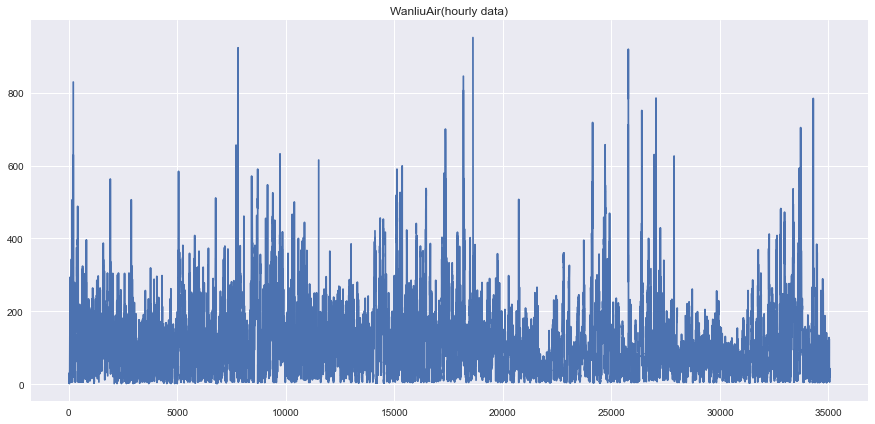

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,8.0,8.0,6.0,28.0,400.0,52.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Wanliu
1,2,2013,3,1,1,9.0,9.0,6.0,28.0,400.0,50.0,-1.1,1023.2,-18.2,0.0,N,4.7,Wanliu
2,3,2013,3,1,2,3.0,6.0,NaN,19.0,400.0,55.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Wanliu
3,4,2013,3,1,3,11.0,30.0,8.0,14.0,NaN,NaN,-1.4,1024.5,-19.4,0.0,NW,3.1,Wanliu
4,5,2013,3,1,4,3.0,13.0,9.0,NaN,300.0,54.0,-2.0,1025.2,-19.5,0.0,N,2.0,Wanliu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,11.0,27.0,4.0,20.0,300.0,81.0,12.6,1011.9,-14.3,0.0,N,2.0,Wanliu
35060,35061,2017,2,28,20,15.0,43.0,6.0,55.0,500.0,45.0,9.4,1012.3,-11.9,0.0,WSW,1.0,Wanliu
35061,35062,2017,2,28,21,13.0,35.0,7.0,48.0,500.0,48.0,8.7,1012.8,-13.7,0.0,N,1.1,Wanliu
35062,35063,2017,2,28,22,12.0,31.0,5.0,47.0,500.0,50.0,7.8,1012.9,-12.6,0.0,NNE,1.0,Wanliu


In [956]:
wlordi = pd.read_csv('PRSA_Data_Wanliu_20130301-20170228.csv')      #导入数据

plt.figure(figsize=(15, 7))
plt.plot(wlordi.PM10)                                               #实际上我们会用PM2.5计算操作只是看看PM10
plt.title('WanliuAir(hourly data)')
plt.grid(True)
plt.show()

wlordi#看一下数据

# 设置时间戳

In [916]:
def setdatetime(x):
    periods = pd.PeriodIndex(year = wanliu["year"],month = wanliu["month"],day = wanliu["day"], hour = wanliu["hour"],freq="H")
    x['Period']=periods#Period格式的时间戳
    x["Period"] = x["Period"].dt.to_timestamp('s').dt.strftime('%Y-%m-%d %H:%M:%S.000') #转为object
    x["Period"] = pd.to_datetime(x['Period'],format='%Y-%m-%d %H:%M:%S.000')            #转为datetime64格式，必须这个格式时间戳
    x = x.set_index('Period')
    return x

In [955]:
serieswanliu = wlordi.copy(deep=True)              #不影响原始数据
serieswanliu = setdatetime(serieswanliu)
print(wanliu.isnull().sum())                        #看一下缺了多少
serieswanliu.fillna(method='ffill',inplace=True)   #不多的情况下，以上一步填充

No            0
year          0
month         0
day           0
hour          0
PM2.5       382
PM10        284
SO2         575
NO2        1070
CO         1812
O3         2107
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd          123
WSPM         14
station       0
dtype: int64


# S24设置

In [918]:
class hourseason:
    def __init__(self,df,dataname):
        self.df = df
        self.dataname = dataname
        self.seasonindexlist=[]
        self.df['hour'] = self.df.index.hour                                          #提取时间做列
        self.seasonindexcol = []                                                      #输出季节参数列
        self.lists24 = []                                                             #后面拟合预测所需要
        
    def seekratio(self):
        rolling24 = self.df[self.dataname].rolling(window=24,center=True)             #计算24小时的移动平均
        rolling_mean24 = rolling24.mean()
        self.df['rolling_mean24'] = rolling_mean24 
        rolling2 = self.df['rolling_mean24'].rolling(window=2,center=True,axis=0)     #24*2的移动平均
        rolling_mean2 = rolling2.mean()
        self.df['rolling_mean2'] = rolling_mean2
        rolling_mean242 = rolling2.mean()
        for i in range(len(rolling_mean2)-1):
            rolling_mean242[i] = rolling_mean2[i+1]                                    #代码与实际有行移动，调整回来
        rolling_mean242[len(rolling_mean2)-1] = np.nan
        self.df['CMA'] = rolling_mean242                                               #24*2就是CMA
        try:  #防止因为这俩列已删导致的报错
            self.df.drop(columns = ['rolling_mean24','rolling_mean2'],inplace = True)
        except Exception as e:
            print(e)
        self.df['ratio'] = self.df.apply(lambda x: x[self.dataname]/x['CMA'],axis=1)  #计算比例，下一步计算季节指数
              
    def seasonindexlistseek(self):
        list0=[]    #笨办法
        list1=[]
        list2=[]
        list3=[]
        list4=[]
        list5=[]
        list6=[]
        list7=[]
        list8=[]
        list9=[]
        list10=[]
        list11=[]
        list12=[]
        list13=[]
        list14=[]
        list15=[]
        list16=[]
        list17=[]
        list18=[]
        list19=[]
        list10=[]
        list21=[]
        list22=[]
        list23=[]
        
        list0 = self.df.loc[(self.df['hour'] == 0)]   #提取对应小时的行
        list1 = self.df.loc[(self.df['hour'] == 1)]
        list2 = self.df.loc[(self.df['hour'] == 2)]
        list3 = self.df.loc[(self.df['hour'] == 3)]
        list4 = self.df.loc[(self.df['hour'] == 4)]
        list5 = self.df.loc[(self.df['hour'] == 5)]
        list6 = self.df.loc[(self.df['hour'] == 6)]
        list7 = self.df.loc[(self.df['hour'] == 7)]
        list8 = self.df.loc[(self.df['hour'] == 8)]
        list9 = self.df.loc[(self.df['hour'] == 9)]
        list10= self.df.loc[(self.df['hour'] == 10)]
        list11= self.df.loc[(self.df['hour'] == 11)]
        list12= self.df.loc[(self.df['hour'] == 12)]
        list13= self.df.loc[(self.df['hour'] == 13)]
        list14= self.df.loc[(self.df['hour'] == 14)]
        list15= self.df.loc[(self.df['hour'] == 15)]
        list16= self.df.loc[(self.df['hour'] == 16)]
        list17= self.df.loc[(self.df['hour'] == 17)]
        list18= self.df.loc[(self.df['hour'] == 18)]
        list19= self.df.loc[(self.df['hour'] == 19)]
        list20= self.df.loc[(self.df['hour'] == 20)]
        list21= self.df.loc[(self.df['hour'] == 21)]
        list22= self.df.loc[(self.df['hour'] == 22)]
        list23= self.df.loc[(self.df['hour'] == 23)]
        
        avg0 = np.mean(list0['ratio'])   #计算指数
        avg1 = np.mean(list1['ratio'])
        avg2 = np.mean(list2['ratio'])
        avg3 = np.mean(list3['ratio'])
        avg4 = np.mean(list4['ratio'])
        avg5 = np.mean(list5['ratio'])
        avg6 = np.mean(list6['ratio'])
        avg7 = np.mean(list7['ratio'])
        avg8 = np.mean(list8['ratio'])
        avg9 = np.mean(list9['ratio'])
        avg10 = np.mean(list10['ratio'])
        avg11 = np.mean(list11['ratio'])
        avg12 = np.mean(list12['ratio'])
        avg13 = np.mean(list13['ratio'])
        avg14 = np.mean(list14['ratio'])
        avg15 = np.mean(list15['ratio'])
        avg16 = np.mean(list16['ratio'])
        avg17 = np.mean(list17['ratio'])
        avg18 = np.mean(list18['ratio'])
        avg19 = np.mean(list19['ratio'])
        avg20 = np.mean(list20['ratio'])
        avg21 = np.mean(list21['ratio'])
        avg22 = np.mean(list22['ratio'])
        avg23 = np.mean(list23['ratio'])
        
        avglist=[avg0,avg1,avg2,avg3,avg4,avg5,avg6,avg7,avg8,avg9,
         avg10,avg11,avg12,avg13,avg14,avg15,avg16,avg17,avg18,avg19,
         avg20,avg21,avg22,avg23]         #指数列表
        sumavg = sum(avglist)             #平均处理
        
        for i in range(24):
            self.seasonindexlist.append(avglist[i]*24/sumavg)    #季节指数
                
    def dealseason(self):
        for i in self.df['hour']:
            self.seasonindexcol.append(self.seasonindexlist[i%24])                                #季节指数列代入df中
        self.df['seasonindex'] = self.seasonindexcol
        self.df['seasonresid'] = self.df.apply(lambda x:x[self.dataname]/x['seasonindex'],axis=1)#计算剩余残差
        try:  #防止多删报错，删去多余列
            self.df.drop(columns = ['CMA','ratio'],inplace = True)
        except Exception as e:
            print(e)
        self.lists24 = self.df['seasonindex'][30684:30784]    #截取预测的100项部分的24小时季节性
        
    def printsolve(self):
        print(self.df.head())
        print(self.seasonindexlist)    

# 年度趋势计算

In [919]:
class seekyeartrendresid:
    def __init__(self,df,dataname,seasonmodel):
        self.df = df
        self.dataname = dataname
        self.seasonmodel = seasonmodel
        self.listt =[]                                                    #预测部分的趋势
        self.lists365 =[]                                                 #预测部分的年份季节性
            
    def modelset(self):
        datadf = self.df[self.dataname]
        seasonal_decomp = seasonal_decompose(datadf, model=self.seasonmodel,period=24*365)
        self.df['trend365'] = seasonal_decomp.trend
        self.df['seasonal365']=seasonal_decomp.seasonal
        self.df['resid365']=seasonal_decomp.resid
        lengths = len(self.df[self.dataname])
        NOlist = []
        for i in range(lengths):
            NOlist.append(i+1)
        self.df['NO'] = NOlist                                #提取NO数值
        plt.rc("figure", figsize=(10, 4))
        seasonal_decomp.plot();
        self.lists365 = self.df['seasonal365'][30684:30784]   #提取预测的年份季节性
    
    def seeklinetrend(self):
        z = sm.add_constant(self.df['NO'][30684:30784])       #提取预测部分的自变量值
        self.df.dropna(inplace=True)
        y = self.df['trend365']
        x = self.df['NO']
        results = sm.OLS(y,sm.add_constant(x)).fit()
        self.df['trendpredicted'] = results.predict()         #回归预测
        self.listt = results.predict(z)                       #提取预测部分的趋势预测值
        self.df['truthresid'] = self.df.apply(lambda x: x[self.dataname]/(x['trendpredicted']*x['seasonal365']),axis=1)
        try:
            self.df.drop(columns = ['seasonresid','trend365','resid365','NO','hour'],inplace = True)
        except Exception as e:
            print(e)        

    def seekexptrend(self):    
        z = sm.add_constant(self.df['NO'][30684:30784])
        self.df.dropna(inplace=True)
        self.df['log'] = self.df['trend365'].apply(lambda x:math.log(x))
        y = self.df['log']
        x = self.df['NO']
        results = sm.OLS(y,sm.add_constant(x)).fit()
        loglistt = []
        loglistt = results.predict(z)
        for i in range(len(loglistt)):
            self.listt.append(math.exp(loglistt[i]))
        self.df['logpredict'] = results.predict()
        self.df['trendpredicted'] = self.df['logpredict'].apply(lambda x:math.exp(x))
        self.df['truthresid'] = self.df.apply(lambda x: x[self.dataname]/(x['trendpredicted']*x['seasonal365']),axis=1)
        try:
            self.df.drop(columns = ['seasonresid','trend365','resid365','NO','hour','log','logpredict'],inplace = True)
        except Exception as e:
            print(e)
                 
    def printinf(self):
        print(self.seasonmodel)
        print(self.df.head())              

multiple
                     PM2.5  seasonindex  seasonal365  trendpredicted  \
Period                                                                 
2013-08-30 12:00:00    6.0     0.912478     0.660288       96.464496   
2013-08-30 13:00:00    5.0     0.905226     0.671108       96.463281   
2013-08-30 14:00:00    4.0     0.894490     0.724044       96.462066   
2013-08-30 15:00:00    3.0     0.888711     0.679741       96.460851   
2013-08-30 16:00:00    3.0     0.879751     0.660931       96.459636   

                     truthresid  
Period                           
2013-08-30 12:00:00    0.103235  
2013-08-30 13:00:00    0.085322  
2013-08-30 14:00:00    0.064027  
2013-08-30 15:00:00    0.051483  
2013-08-30 16:00:00    0.053488  


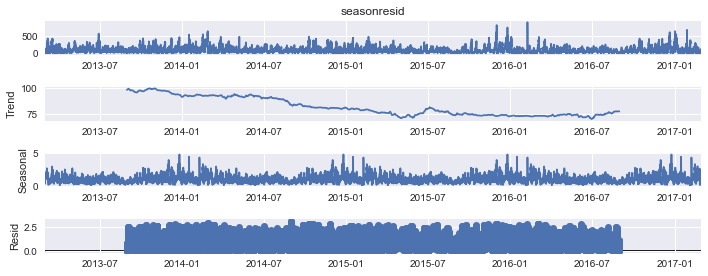

In [938]:
seriestrain = serieswanliu.copy(deep=True)
seriestrain.drop(columns = ['No','year','month','day','hour','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','wd','WSPM','station'],inplace = True)
seriestrain.fillna(method='ffill',inplace=True)
serie = hourseason(seriestrain,'PM2.5')
serie.seekratio()
serie.seasonindexlistseek()
serie.dealseason()

series = seekyeartrendresid(seriestrain,'seasonresid','multiple')
series.modelset()
series.seekexptrend()

series.printinf()

# 时间序列信息绘总

In [921]:
class timeseriesinformation:
    def __init__(self,df,dataname):
        self.df = df
        self.dataname = dataname
    
    def adftest(self):
        adf = adfuller(self.df[self.dataname])
        print(adf)
    
    def qlbtest(self):
        lags = [1,2,3,4,5,6,8,12,16,32]
        LB = sm.stats.diagnostic.acorr_ljungbox(self.df[self.dataname],lags = lags,return_df = True)
        print("序列resid的检验结果:\n",LB)
    
    def acfpacfplot(self):
        fig = plt.figure(figsize=(8,6))
        ax1=fig.add_subplot(211)
        fig = sm.graphics.tsa.plot_acf(self.df[self.dataname],lags=50,ax=ax1)
        ax2 = fig.add_subplot(212)
        fig = sm.graphics.tsa.plot_pacf(self.df[self.dataname],lags=50,ax=ax2)
        plt.show() 

(-20.452974054522414, 0.0, 24, 26279, {'1%': -3.430598865591385, '5%': -2.8616499912924853, '10%': -2.5668285451079353}, -15447.07627714963)
序列resid的检验结果:
           lb_stat  lb_pvalue
1    24437.590985        0.0
2    46756.858866        0.0
3    67112.957649        0.0
4    85687.547233        0.0
5   102641.465923        0.0
6   118093.892053        0.0
8   145140.320047        0.0
12  187364.257138        0.0
16  217946.290592        0.0
32  270358.654064        0.0


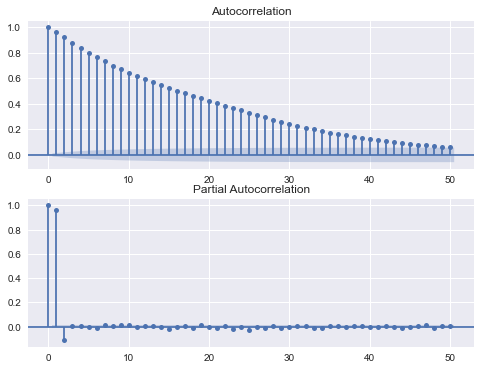

In [922]:
information = timeseriesinformation(seriestrain,'truthresid')
information.adftest()
information.qlbtest()
information.acfpacfplot()

# 时间序列调参

In [463]:
def seekarmapara(x,a,b):
    bic = []
    biclist = []
    bicpara=[]
    
    for i in range(0,a):
        for j in range(0,b):
            try:                                                 #防止模型无法形成导致报错从而无法调参
                arma = ARIMA(x.tolist(),order = (i,0,j)).fit()
                bic.append([i,j,arma.bic])
            except Exception as e:
                print(e)
                
    for i in range(len(bic)):
        biclist.append(bic[i][2])
        
    bictrue = min(biclist)                                       #最合适的bic
    
    for i in range(len(bic)):
        if bic[i][2] == bictrue:
            bicpara.append([bic[i][0],bic[i][1],bic[i][2]])      #筛选最好结果
            
    return bic,bicpara

In [489]:
para=seekarmapara(seriestrain.truthresid,10,10)                  #展示出报错信息

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not

In [490]:
para    #bic列表和最优参数

([[0, 0, 54442.40301630936],
  [0, 1, 26495.265088098662],
  [0, 4, -3126.6765908377974],
  [0, 5, -6461.984823257882],
  [0, 6, -8572.87029510088],
  [0, 7, -10096.514288992195],
  [0, 8, -11230.015657972428],
  [0, 9, -12022.005602988462],
  [1, 0, -15120.724150811699],
  [1, 1, -15432.993657811097],
  [1, 2, -15425.110955552555],
  [1, 3, -15415.086539881446],
  [1, 4, -15405.320407596186],
  [1, 5, -15398.436359710575],
  [1, 6, -15393.364972844367],
  [1, 7, -15383.265964841776],
  [1, 8, -15378.153155708937],
  [1, 9, -15374.330825090054],
  [2, 0, -15434.74674793991],
  [2, 1, -15424.990963381053],
  [2, 2, -15415.003846748437],
  [2, 3, -15406.917034119224],
  [3, 0, -15425.01763369557],
  [3, 1, -15416.32628853105],
  [3, 2, -15405.033241308514],
  [3, 3, -15406.328126059792],
  [4, 0, -15415.157992486256],
  [4, 1, -15404.985030571728],
  [4, 2, -15409.947765497627],
  [4, 3, -15396.162334854012],
  [4, 4, -15390.082421521132],
  [5, 0, -15405.004355741288],
  [5, 1, -15398.6

# 模型拟合评价与拟合效果例

In [939]:
armodel = ARIMA(seriestrain.truthresid,order = (2,0,0)).fit()
print(armodel.summary())

                              ARMA Model Results                              
Dep. Variable:             truthresid   No. Observations:                26304
Model:                     ARMA(2, 0)   Log Likelihood                7737.728
Method:                       css-mle   S.D. of innovations              0.180
Date:                Mon, 09 Jan 2023   AIC                         -15467.457
Time:                        23:41:50   BIC                         -15434.747
Sample:                    08-30-2013   HQIC                        -15456.895
                         - 08-30-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9901      0.028     35.795      0.000       0.936       1.044
ar.L1.truthresid     1.0705      0.006    174.702      0.000       1.059       1.083
ar.L2.truthresid    -0.1107 

(-31.097499122603654, 0.0, 23, 26280, {'1%': -3.4305988561206884, '5%': -2.861649987106891, '10%': -2.5668285428800366}, -15444.131380570492)
序列resid的检验结果:
       lb_stat  lb_pvalue
1    0.006145   0.937520
2    0.331559   0.847233
3    0.621529   0.891487
4    0.691655   0.952354
5    3.417929   0.635841
6    9.000291   0.173562
8   13.952577   0.083010
12  17.422834   0.134372
16  33.690945   0.005978
32  81.505600   0.000003


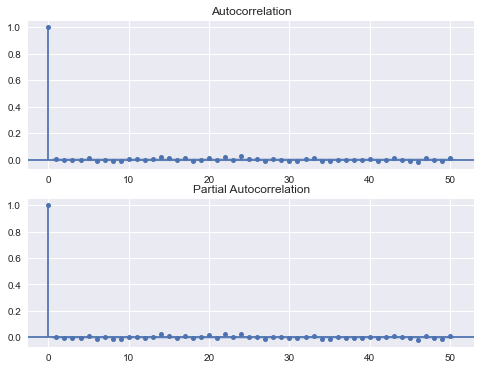

In [940]:
seriestrain['truthresidpredicted'] = armodel.predict()
seriestrain['truthresidresid'] = armodel.resid

informationresid = timeseriesinformation(seriestrain,'truthresidresid')
informationresid.adftest()
informationresid.qlbtest()
informationresid.acfpacfplot()

In [941]:
def seekpredictPM(x):#对PM2.5的拟合而非是分解后的残差项的拟合
    x['predictPM'] = x.apply(lambda x: x['truthresidpredicted']*x['seasonindex']*x['trendpredicted']*x['seasonal365'],axis=1)
    try:
        x.drop(columns = ['truthresidresid'],inplace = True)
    except Exception as e:
        print(e)
    return x

In [942]:
getpredicPM=seekpredictPM(seriestrain) #提取拟合

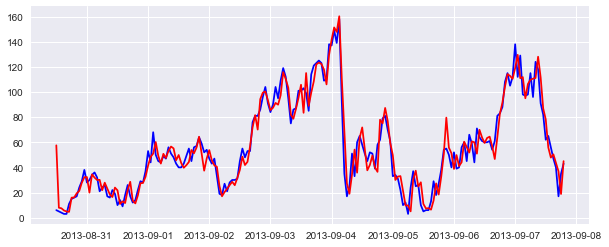

In [943]:
plt.figure(figsize=(10,4))
plt.plot(seriestrain['PM2.5'][0:200],color='blue')
plt.plot(seriestrain['predictPM'][0:200],color='red')

plt.show()

# 时间序列预测例

In [944]:
def timeseriesforecast(x):
    ts_ARIMA= x.astype(float)
    model = sm.tsa.statespace.SARIMAX(x,order = (1,0,1))
    fit1 = model.fit()
    y_hat_ARIMA = fit1.get_forecast(steps=100)              #100项预测
    
    listPM=[]
    listPM = serieswanliu['PM2.5'][30684:30784]
    forecast100 = pd.DataFrame(y_hat_ARIMA.predicted_mean)  #预测df
    forecast100['PM2.5'] = listPM
    forecast100['season24'] = serie.lists24
    forecast100['season365'] = series.lists365
    forecast100['trend'] = series.listt                     #预测PM的制作
    forecast100['forecastPM'] = forecast100.apply(lambda x: x['predicted_mean']*x['season24']*x['season365']*x['trend'],axis=1)

    plt.figure(figsize=(10,4))
    plt.plot(forecast100['PM2.5'],color='blue')
    plt.plot(forecast100['forecastPM'],color='red')  
    plt.show()

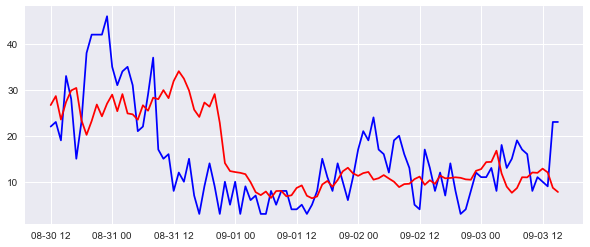

In [945]:
forecastPM100 = timeseriesforecast(seriestrain.truthresid)  #预测效果

# 各变量关系的可视化展示

In [946]:
paintwanliu = wlordi.copy(deep=True)
paintwanliu = setdatetime(paintwanliu)
paintwanliu.fillna(method='ffill',inplace=True)

In [947]:
class paintwanliudf:
    def __init__(self,df,dataname):
        self.df = df
        self.dataname = dataname
        
    def acfpacfplot(self):
        fig = plt.figure(figsize=(8,6))
        ax1=fig.add_subplot(211)
        fig = sm.graphics.tsa.plot_acf(self.df[self.dataname],lags=50,ax=ax1)
        ax2 = fig.add_subplot(212)
        fig = sm.graphics.tsa.plot_pacf(self.df[self.dataname],lags=50,ax=ax2)
        plt.show() 
        
    def scattermatrix(self):
        dfpaint = self.df.copy(deep=True)
        try:
            dfpaint.drop(columns = ['No','year','month','day','hour','wd','station'],inplace = True)
        except Exception as e:
            print(e)
        fig = plt.figure(figsize=(6,6))
        fig = pd.plotting.scatter_matrix(dfpaint,ax=fig.add_subplot(111)) # 矩阵散点图
        plt.show() # 展示图表
        
    def histpaint(self):
        dfpaint = self.df.copy(deep=True)
        try:
            dfpaint.drop(columns = ['No','year','month','day','hour','wd','station'],inplace = True)
        except Exception as e:
            print(e)
        fig = plt.figure(figsize=(6,6))
        fig = dfpaint.hist(ax=fig.add_subplot(111))
        plt.show() # 展示图表    
        
    def boxpaint(self):
        dfpaint = self.df.copy(deep=True)
        try:
            dfpaint.drop(columns = ['No','year','month','day','hour','wd','station','CO','PRES'],inplace = True)
        except Exception as e:
            print(e)
        fig = plt.figure(figsize=(6,6))
        fig = dfpaint.plot(kind='box',ax=fig.add_subplot(111))
        plt.show() # 展示图表    
       
    def heatmappaint(self):
        dfpaint = self.df.copy(deep=True)
        try:
            dfpaint.drop(columns = ['No','year','month','day','hour','wd','station'],inplace = True)
        except Exception as e:
            print(e)
        fig = plt.figure(figsize=(8,6))
        sns.heatmap(dfpaint.corr(), annot = True, linewidths=.5, cmap="YlGnBu") 
        plt.title('Correlation between features', fontsize = 30)
        plt.tight_layout()        

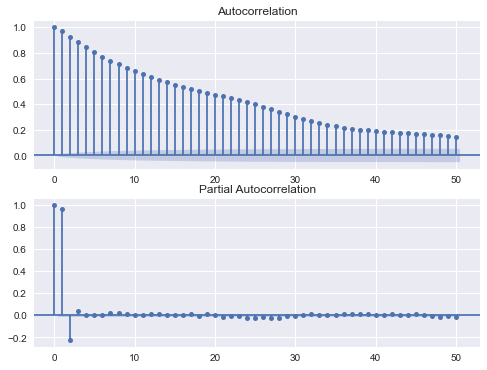

In [948]:
example5 = paintwanliudf(paintwanliu,'PM2.5')
example5.acfpacfplot()

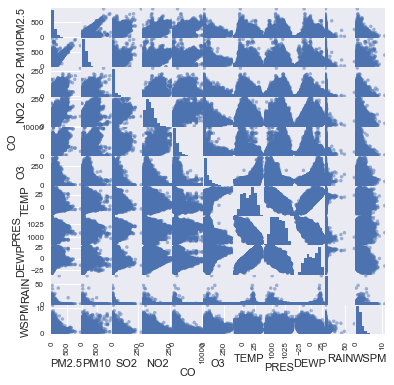

In [545]:
example5.scattermatrix()

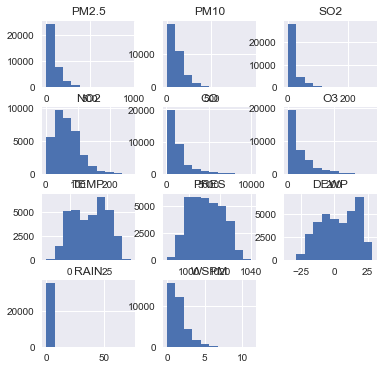

In [546]:
example5.histpaint()

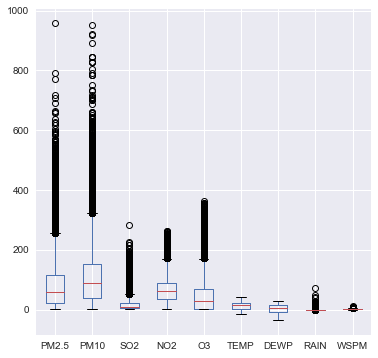

In [547]:
example5.boxpaint()

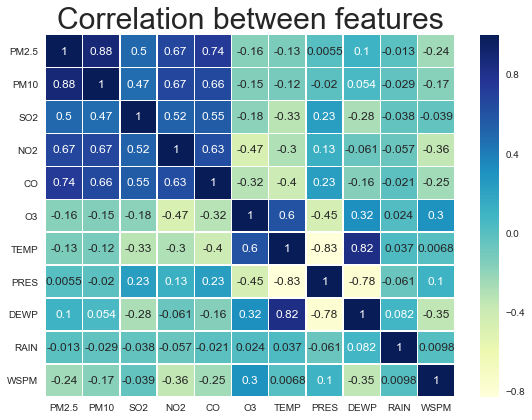

In [949]:
example5.heatmappaint()

# SVM方法

In [973]:
svmwanliu = wlordi.copy(deep=True)
svmwanliu.fillna(method='ffill',inplace=True)
svmwanliu.drop(columns = ['year','month','day','wd','station'],inplace=True)
svmwanliu.head()
X=svmwanliu[['PM10','SO2','NO2','CO']]  #分析的所需的x
Y=svmwanliu[['PM2.5']]
# 数据预处理
Stand_X = StandardScaler()              # 特征进行标准化
Stand_Y = StandardScaler()              # 标签也是数值，也需要进行标准化
STANDX = Stand_X.fit_transform(X)
STANDY = Stand_Y.fit_transform(Y) 
train_data = STANDX[0:24534]            #手动分割！否则可能导致index错误
test_data = STANDX[24534:]
train_target = STANDY[0:24534]
test_target = STANDY[24534:]

In [872]:
 # ① 线性核函数
clf = LinearSVR(C=2)
clf.fit(train_data,train_target)
y_pred = clf.predict(test_data)
print("线性核函数：")
print("训练集评分：", clf.score(train_data,train_target))
print("测试集评分：", clf.score(test_data,test_target))
print("测试集均方差：",metrics.mean_squared_error(test_target,y_pred.reshape(-1,1)))
print("测试集R2分：",metrics.r2_score(test_target,y_pred.reshape(-1,1)))

# ② 高斯核函数
clf = SVR(kernel='rbf',C=10,gamma=0.1,coef0=0.1)
clf.fit(train_data,train_target)
y_pred = clf.predict(test_data)
print("高斯核函数：")
print("训练集评分：", clf.score(train_data,train_target))
print("测试集评分：", clf.score(test_data,test_target))
print("测试集均方差：",metrics.mean_squared_error(test_target,y_pred.reshape(-1,1)))
print("测试集R2分：",metrics.r2_score(test_target,y_pred.reshape(-1,1)))

# ③ sigmoid核函数
clf = SVR(kernel='sigmoid',C=2)
clf.fit(train_data,train_target)
y_pred = clf.predict(test_data)
print("sigmoid核函数：")
print("训练集评分：", clf.score(train_data,train_target))
print("测试集评分：", clf.score(test_data,test_target))
print("测试集均方差：",metrics.mean_squared_error(test_target,y_pred.reshape(-1,1)))
print("测试集R2分：",metrics.r2_score(test_target,y_pred.reshape(-1,1)))

# ④ 多项式核函数
clf = SVR(kernel='poly',C=2)
clf.fit(train_data,train_target)
y_pred = clf.predict(test_data)
print("多项式核函数：")
print("训练集评分：", clf.score(train_data,train_target))
print("测试集评分：", clf.score(test_data,test_target))
print("测试集均方差：",metrics.mean_squared_error(test_target,y_pred.reshape(-1,1)))
print("测试集R2分：",metrics.r2_score(test_target,y_pred.reshape(-1,1)))

线性核函数：
训练集评分： 0.7777305115446511
测试集评分： 0.8912399635855722
测试集均方差： 0.12023802443359217
测试集R2分： 0.8912399635855723
高斯核函数：
训练集评分： 0.8795132747070469
测试集评分： 0.8950209950857735
测试集均方差： 0.11605796185828146
测试集R2分： 0.8950209950857735
sigmoid核函数：
训练集评分： -2636161.8723996677
测试集评分： -1741734.4621595275
测试集均方差： 1925549.4753421207
测试集R2分： -1741734.4621595275
多项式核函数：
训练集评分： 0.2423683952722786
测试集评分： -0.4555311384080736
测试集均方差： 1.6091405846619227
测试集R2分： -0.4555311384080736


In [954]:
# 调参
clf = GridSearchCV(SVR(),param_grid={'kernel':['poly','sigmoid','rbf'],'C': [0.1,1,5,10,15],'gamma':[0.01,0.05,0.1,0.5,1,5,10]},cv=5)
clf.fit(train_data,train_target)
print("best_param:",clf.best_params_)
print("best_score:", clf.best_score_)

best_param: {'C': 10, 'gamma': 0.05, 'kernel': 'rbf'}
best_score: 0.823150358665206


In [974]:
#按照调参结果进行建模
clf = SVR(kernel='rbf',C=10,gamma=0.05,coef0=0.1)
clf.fit(train_data,train_target)
y_pred = clf.predict(test_data)
print("高斯核函数：")
print("训练集评分：", clf.score(train_data,train_target))
print("测试集评分：", clf.score(test_data,test_target))
print("测试集均方差：",metrics.mean_squared_error(test_target,y_pred.reshape(-1,1)))
print("测试集R2分：",metrics.r2_score(test_target,y_pred.reshape(-1,1)))

高斯核函数：
训练集评分： 0.8757893115005596
测试集评分： 0.8972561502072861
测试集均方差： 0.11358343041205636
测试集R2分： 0.8972561502072862


# 综合预测拟合效果

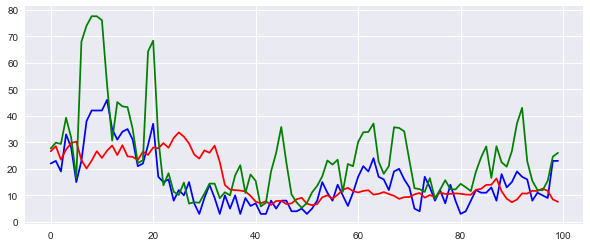

In [975]:
pred =forecast100.copy(deep=True)          #预测df
index = []
for i in range(len(pred['PM2.5'])):
    index.append(i)
pred['index'] = index
pred = pred.set_index('index')              #统一index，SVM的index是0开始而非datetime格式
pred.fillna(method='ffill',inplace=True)

ORIGINY = Stand_Y.inverse_transform(y_pred) #逆标准化
Z=ORIGINY[6150:6250]                        #截取预测部分

plt.figure(figsize=(10,4))
plt.plot(pred['PM2.5'],color='blue')
plt.plot(pred['forecastPM'],color='red')  
plt.plot(Z,color='green')
plt.show()

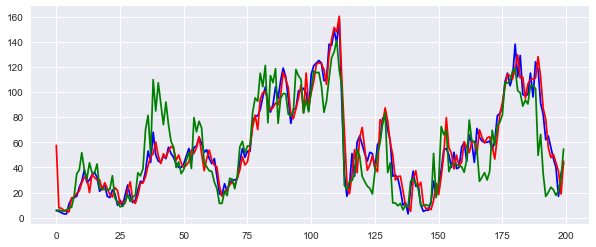

In [976]:
testing = seriestrain.copy(deep=True)
testing = testing[0:200]                    #截取拟合部分
index = []
for i in range(200):
    index.append(i)
testing['index'] = index
testing = testing.set_index('index')        #index调整

y_test = clf.predict(train_data)
ORIGINT = Stand_Y.inverse_transform(y_test)
T=ORIGINT[4380:4580]                        #截取拟合部分的拟合值

plt.figure(figsize=(10,4))
plt.plot(testing['PM2.5'],color='blue')
plt.plot(testing['predictPM'],color='red')  
plt.plot(T,color='green')
plt.show()

# 数据输出

In [990]:
SVMwanliuPre = wlordi.copy(deep=True) 

In [987]:
seriestrain.to_csv('Wanliu_PM2.5_Timeseries_Predict.csv', index=False)
ORIGIN = np.concatenate((ORIGINT,ORIGINY),axis = 0)
ORIGINDF = pd.DataFrame(ORIGIN)
ORIGINDF.to_csv('Wanliu_PM2.5_SVM_Predict.csv', index=False)